# Introduction to Neural Networks
Author: Marieme Ngom, adapting materials from Bethany Lusch, Asad Khan, Prasanna Balaprakash, Taylor Childers, Corey Adams, Kyle Felker, and Tanwi Mallick.

This tutorial will serve as a gentle introduction to neural networks and deep learning through a hands-on classification problem using the MNIST dataset.

In particular, we will introduce neural networks and how to train and improve their learning capabilities.  We will use the PyTorch Python library.

The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) contains thousands of examples of handwritten numbers, with each digit labeled 0-9.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/mnist_task.png?raw=1"  align="left"/>



In [ ]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy
import matplotlib.pyplot as plt
import time

## The MNIST dataset

We will now download the dataset that contains handwritten digits. MNIST is a popular dataset, so we can download it via the PyTorch library. Note:
- x is for the inputs (images of handwritten digits) and y is for the labels or outputs (digits 0-9)
- We are given "training" and "test" datasets. Training datasets are used to fit the model. Test datasets are saved until the end, when we are satisfied with our model, to estimate how well our model generalizes to new data.

Note that downloading it the first time might take some time.
The data is split as follows:
- 60,000 training examples, 10,000 test examples
- inputs: 1 x 28 x 28 pixels
- outputs (labels): one integer per example

In [ ]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [ ]:
train_size = int(0.8 * len(training_data))  # 80% for training
val_size = len(training_data) - train_size  # Remaining 20% for validation
training_data, validation_data = torch.utils.data.random_split(training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55))

In [ ]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

Let's take a closer look. Here are the first 10 training digits:

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

# Generalities:
To train our classifier, we need (besides the data):
- A model that depend on parameters $\mathbf{\theta}$. Here we are going to use neural networks.
- A loss function $J(\mathbf{\theta})$ to measure the capabilities of the model.
- An optimization method.

# Linear Model
Let's begin with a simple linear model: linear regression, like last week.
We add one complication: each example is a vector (flattened image), so the "slope" multiplication becomes a dot product. If the target output is a vector as well, then the multiplication becomes matrix multiplication.

Note, like before, we consider multiple examples at once, adding another dimension to the input.


 <img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/LinearModel_1.png?raw=1"  align="center"/>



The linear layers in PyTorch perform a basic $xW + b$. These "fully connected" layers connect each input to each output with some weight parameter. We wouldn't expect a simple linear model $f(x) = xW+b$ directly outputting the class label and minimizing mean squared error to work well - the model would output labels like 3.55 and 2.11 instead of skipping to integers.

We now need:
- A loss function $J(\theta)$ where $\theta$ is the list of parameters (here W and b). Last week, we used mean squared error (MSE), but this week let's make two changes that make more sense for classification:
    - Change the output to be a length-10 vector of class probabilities (0 to 1, adding to 1).
    - Cross entropy as the loss function, which is typical for classification. You can read more [here](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

- An optimization method or optimizer such as the stochastic gradient descent (sgd) method, the Adam optimizer, RMSprop, Adagrad etc. Let's start with stochastic gradient descent (sgd), like last week. For far more information about more advanced optimizers than basic SGD, with some cool animations, see https://ruder.io/optimizing-gradient-descent/ or https://distill.pub/2017/momentum/.

- A learning rate. As we learned last week, the learning rate controls how far we move during each step.

In [ ]:
class LinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()

        # First, we need to convert the input image to a vector by using
        # nn.Flatten(). For MNIST, it means the second dimension 28*28 becomes 784.
        self.flatten = nn.Flatten()

        # Here, we add a fully connected ("dense") layer that has 28 x 28 = 784 input nodes
        #(one for each pixel in the input image) and 10 output nodes (for probabilities of each class).
        self.layer_1 = nn.Linear(28*28, 10)

    def forward(self, x):

        x = self.flatten(x)
        x = self.layer_1(x)

        return x

In [ ]:
linear_model = LinearClassifier()
print(linear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(linear_model.parameters(), lr=0.05)

# Learning
Now we are ready to train our first model. A training step is comprised of:
- A forward pass: the input is passed through the network
- Backpropagation: A backward pass to compute the gradient $\frac{\partial J}{\partial \mathbf{W}}$ of the loss function with respect to the parameters of the network.
- Weight updates $\mathbf{W} = \mathbf{W} - \alpha \frac{\partial J}{\partial \mathbf{W}} $ where $\alpha$ is the learning rate.

How many steps do we take?
- The batch size corresponds to the number of training examples in one pass (forward + backward). A smaller batch size allows the model to learn from individual examples but takes longer to train. A larger batch size requires fewer steps but may result in the model not capturing the nuances in the data. The higher the batch size, the more memory you will require.  
- An epoch means one pass through the whole training data (looping over the batches). Using few epochs can lead to underfitting and using too many can lead to overfitting.
- The choice of batch size and learning rate are important for performance, generalization and accuracy in deep learning.






In [ ]:
batch_size = 128

# The dataloader makes our dataset iterable
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

In [ ]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backward pass calculates gradients
        loss.backward()

        # take one step with these gradients
        optimizer.step()

        # resets the gradients
        optimizer.zero_grad()

In [ ]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size

    accuracy = 100*correct
    return accuracy, loss

In [ ]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, linear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, linear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, linear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# Visualize how the model is doing on the first 10 examples
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))
linear_model.eval()
batch = next(iter(train_dataloader))
predictions = linear_model(batch[0])

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(batch[0][i,0,:,:], cmap="gray")
    plt.title('%d' % predictions[i,:].argmax())

Exercise: How can you improve the accuracy? Some things you might consider: increasing the number of epochs, changing the learning rate, etc.

# Prediction

Let's see how our model generalizes to the unseen test data.



In [ ]:
#create dataloader for test data
# The dataloader makes our dataset iterable
batch_size_test = 256
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size_test)

In [ ]:
acc_test, loss_test = evaluate(test_dataloader, linear_model, loss_fn)
print("Test loss: %.4f, test accuracy: %.2f%%" % (loss_test, acc_test))

We can now take a closer look at the results.

Let's define a helper function to show the failure cases of our classifier.

In [ ]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])

    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

Here are the first 10 images from the test data that this small model classified to a wrong class:



In [ ]:
show_failures(linear_model, test_dataloader)

<!-- # Exercise:
- Try changing the loss function,
- Try changing the optimizer -->

# Multilayer Model
Our linear model isn't enough for high accuracy on this dataset. To improve the model, we often need to add more layers and nonlinearities.
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/shallow_nn.png?raw=1"  align="left"/>

The output of this NN can be written as
\begin{equation}\label{eq: NN1d}
  \hat{u}(x) = \sigma_2(\sigma_1(\mathbf{x}\mathbf{W}_1 + \mathbf{b}_1)\mathbf{W}_2 + \mathbf{b}_2),
\end{equation}
where $\mathbf{x}$ is the input, $\mathbf{W}_j$ are the weights of the neural network, $\sigma_j$ the (nonlinear) activation functions, and $\mathbf{b}_j$ its biases. The activation function introduces the nonlinearity and makes it possible to learn more complex tasks. Desirable properties in an activation function include being differentiable, bounded, and monotonic.


Image source: [PragatiBaheti](https://www.v7labs.com/blog/neural-networks-activation-functions)
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/activation.jpeg?raw=1"  align="center"/>

Adding more layers to obtain a deep neural network:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/deep_nn_annotated.jpg?raw=1"  align="left"/>



# Important things to know
Deep Neural networks can be overly flexible/complicated and "overfit" your data, just like fitting overly complicated polynomials:
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/bias_vs_variance.png?raw=1"  align="left"/>


Vizualization wrt to the accuracy and loss (Image source: [Baeldung](https://www.baeldung.com/cs/ml-underfitting-overfitting)):
<img src="https://github.com/argonne-lcf/ai-science-training-series/blob/main/02_intro_neural_networks/images/acc_under_over.webp?raw=1"  align="center"/>


To improve the generalization of our model on previously unseen data, we employ a technique known as regularization, which constrains our optimization problem in order to discourage complex models.

  - Dropout is the commonly used regularization technique. The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting.
  - Penalizing the loss function by adding a term such as $\lambda ||\mathbf{W}||^2$ is alsp a commonly used regularization technique. This helps "control" the magnitude of the weights of the network.
    
Vanishing gradients: Gradients become small as they propagate backward through the layers. Squashing activation functions like sigmoid or tanh could cause this.

Exploding gradients: Gradients grow exponentially usually due to "poor" weight initialization.

<!--  <img src="images/test_data_rule.png" width="800" hight="500" align="center"/>
  -->

We can now implement a deep network in PyTorch. nn.Dropout() performs the Dropout operation mentioned earlier

In [ ]:
class NonlinearClassifier(nn.Module):

    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28*28, 50),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 50),
            nn.ReLU(),
           # nn.Dropout(0.2),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

In [ ]:
nonlinear_model = NonlinearClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.05)

In [ ]:
%%time

epochs = 5
train_acc_all = []
val_acc_all = []
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    train_acc_all.append(acc)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

    # checking on the validation loss and accuracy once per epoch
    val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
    val_acc_all.append(val_acc)
    print(f"Epoch {j}: val. loss: {val_loss}, val. accuracy: {val_acc}")

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, 10 * pltsize))
plt.plot(range(epochs), train_acc_all,label = 'Training Acc.' )
plt.plot(range(epochs), val_acc_all, label = 'Validation Acc.' )
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.legend()

In [ ]:
show_failures(nonlinear_model, test_dataloader)

# Recap
To train and validate a neural network model, you need:
- Data split into training/validation/test sets,
- A model with parameters to learn,
- An appropriate loss function,
- An optimizer (with tunable parameters such as learning rate, weight decay etc.) used to learn the parameters of the model.


# Homework

1. Compare the quality of your model when using different:
 - batch sizes,
 - learning rates,
 - activation functions.

3. Bonus: What is a learning rate scheduler?

If you have time, experiment with how to improve the model. Note: training and validation data can be used to compare models, but test data should be saved until the end as a final check of generalization.

MNIST data loaded: train=48000, val=12000, test=10000
Input shape: torch.Size([1, 28, 28])

Batch Size: 64, Learning Rate: 0.01, Activation: ReLU()
Epoch 0: Train Loss: 1.7786, Train Acc: 56.70%
Epoch 0: Val Loss: 1.7744, Val Acc: 57.31%
Epoch 1: Train Loss: 0.6673, Train Acc: 80.73%
Epoch 1: Val Loss: 0.6617, Val Acc: 80.68%
Epoch 2: Train Loss: 0.4863, Train Acc: 85.95%
Epoch 2: Val Loss: 0.4807, Val Acc: 85.47%
Epoch 3: Train Loss: 0.4114, Train Acc: 88.08%
Epoch 3: Val Loss: 0.4042, Val Acc: 87.93%
Epoch 4: Train Loss: 0.3668, Train Acc: 89.49%
Epoch 4: Val Loss: 0.3583, Val Acc: 89.37%


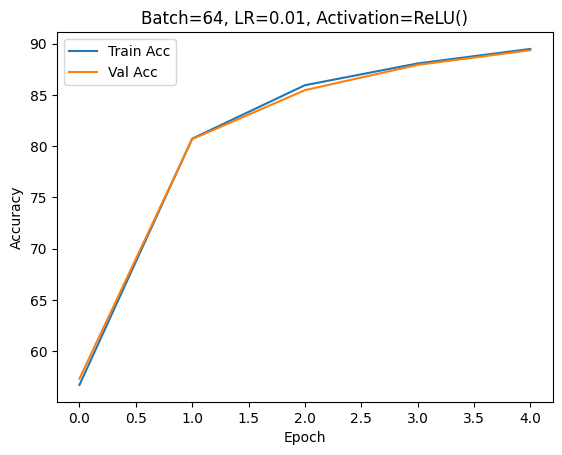

Test Loss: 0.3534, Test Acc: 89.34%
Showing up to 10 first failures:


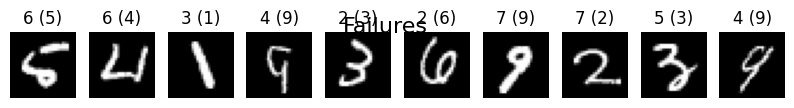


Batch Size: 64, Learning Rate: 0.01, Activation: Tanh()
Epoch 0: Train Loss: 1.2399, Train Acc: 67.49%
Epoch 0: Val Loss: 1.2349, Val Acc: 68.04%
Epoch 1: Train Loss: 0.6556, Train Acc: 83.21%
Epoch 1: Val Loss: 0.6491, Val Acc: 83.11%
Epoch 2: Train Loss: 0.4924, Train Acc: 86.77%
Epoch 2: Val Loss: 0.4855, Val Acc: 86.78%
Epoch 3: Train Loss: 0.4171, Train Acc: 88.70%
Epoch 3: Val Loss: 0.4087, Val Acc: 88.54%
Epoch 4: Train Loss: 0.3755, Train Acc: 89.61%
Epoch 4: Val Loss: 0.3664, Val Acc: 89.61%


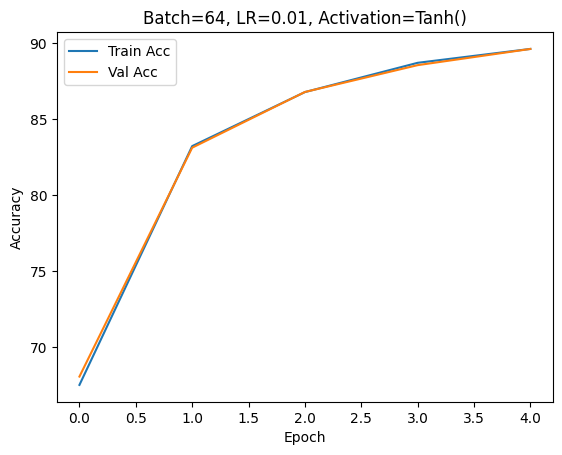

Test Loss: 0.3605, Test Acc: 89.71%
Showing up to 10 first failures:


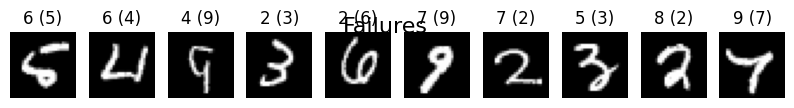


Batch Size: 64, Learning Rate: 0.05, Activation: ReLU()
Epoch 0: Train Loss: 0.3876, Train Acc: 88.72%
Epoch 0: Val Loss: 0.3791, Val Acc: 88.64%
Epoch 1: Train Loss: 0.2973, Train Acc: 91.35%
Epoch 1: Val Loss: 0.2928, Val Acc: 91.04%
Epoch 2: Train Loss: 0.2435, Train Acc: 92.80%
Epoch 2: Val Loss: 0.2431, Val Acc: 92.72%
Epoch 3: Train Loss: 0.2083, Train Acc: 93.76%
Epoch 3: Val Loss: 0.2132, Val Acc: 93.69%
Epoch 4: Train Loss: 0.1868, Train Acc: 94.32%
Epoch 4: Val Loss: 0.1946, Val Acc: 94.12%


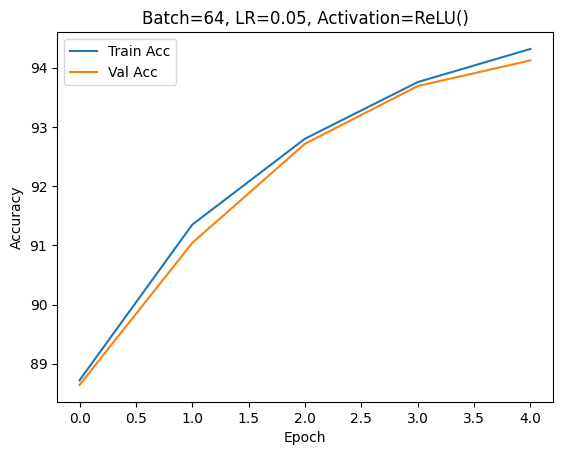

Test Loss: 0.1957, Test Acc: 93.87%
Showing up to 10 first failures:


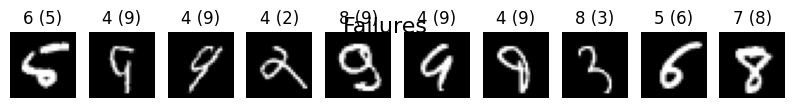


Batch Size: 64, Learning Rate: 0.05, Activation: Tanh()
Epoch 0: Train Loss: 0.3697, Train Acc: 89.50%
Epoch 0: Val Loss: 0.3595, Val Acc: 89.53%
Epoch 1: Train Loss: 0.3005, Train Acc: 91.33%
Epoch 1: Val Loss: 0.2928, Val Acc: 91.31%
Epoch 2: Train Loss: 0.2617, Train Acc: 92.36%
Epoch 2: Val Loss: 0.2582, Val Acc: 92.13%
Epoch 3: Train Loss: 0.2374, Train Acc: 93.00%
Epoch 3: Val Loss: 0.2383, Val Acc: 92.81%
Epoch 4: Train Loss: 0.2142, Train Acc: 93.71%
Epoch 4: Val Loss: 0.2174, Val Acc: 93.45%


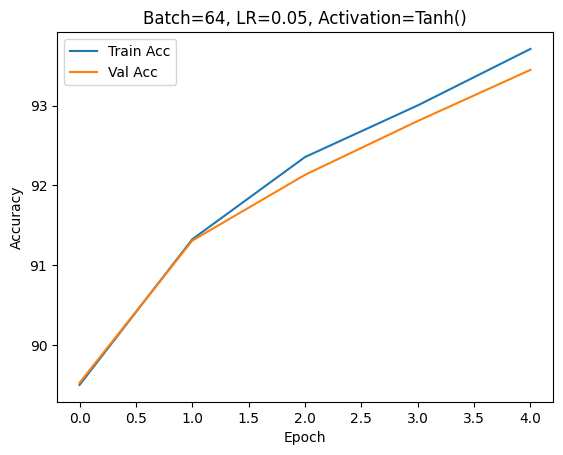

Test Loss: 0.2206, Test Acc: 93.53%
Showing up to 10 first failures:


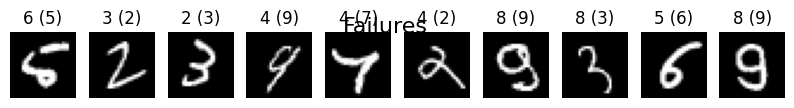


Batch Size: 64, Learning Rate: 0.1, Activation: ReLU()
Epoch 0: Train Loss: 0.2979, Train Acc: 91.24%
Epoch 0: Val Loss: 0.2931, Val Acc: 91.22%
Epoch 1: Train Loss: 0.2102, Train Acc: 93.65%
Epoch 1: Val Loss: 0.2145, Val Acc: 93.40%
Epoch 2: Train Loss: 0.1692, Train Acc: 94.89%
Epoch 2: Val Loss: 0.1767, Val Acc: 94.72%
Epoch 3: Train Loss: 0.1452, Train Acc: 95.59%
Epoch 3: Val Loss: 0.1585, Val Acc: 95.27%
Epoch 4: Train Loss: 0.1325, Train Acc: 95.97%
Epoch 4: Val Loss: 0.1486, Val Acc: 95.50%


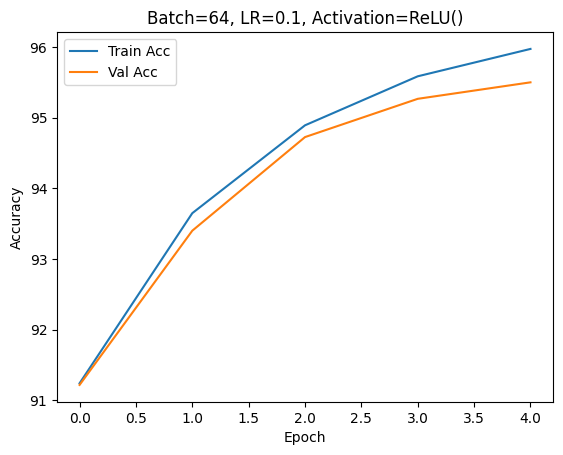

Test Loss: 0.1376, Test Acc: 95.80%
Showing up to 10 first failures:


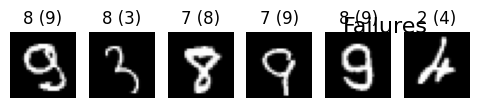


Batch Size: 64, Learning Rate: 0.1, Activation: Tanh()
Epoch 0: Train Loss: 0.2996, Train Acc: 91.41%
Epoch 0: Val Loss: 0.2927, Val Acc: 91.14%
Epoch 1: Train Loss: 0.2416, Train Acc: 92.95%
Epoch 1: Val Loss: 0.2426, Val Acc: 92.61%
Epoch 2: Train Loss: 0.2077, Train Acc: 93.80%
Epoch 2: Val Loss: 0.2145, Val Acc: 93.47%
Epoch 3: Train Loss: 0.1815, Train Acc: 94.54%
Epoch 3: Val Loss: 0.1896, Val Acc: 94.09%
Epoch 4: Train Loss: 0.1651, Train Acc: 95.09%
Epoch 4: Val Loss: 0.1753, Val Acc: 94.48%


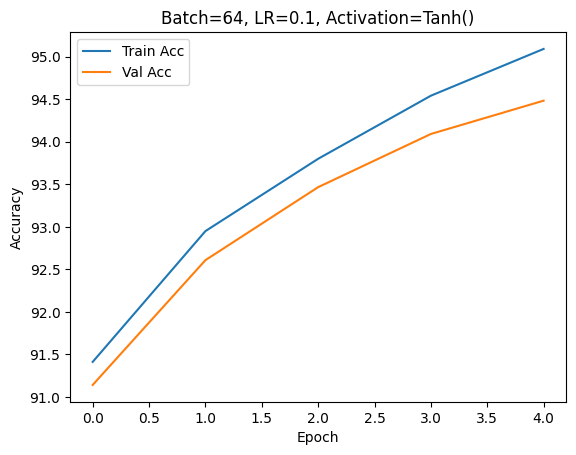

Test Loss: 0.1762, Test Acc: 94.69%
Showing up to 10 first failures:


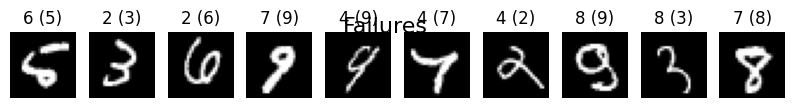


Batch Size: 128, Learning Rate: 0.01, Activation: ReLU()
Epoch 0: Train Loss: 2.2006, Train Acc: 34.21%
Epoch 0: Val Loss: 2.2011, Val Acc: 34.46%
Epoch 1: Train Loss: 1.6771, Train Acc: 43.33%
Epoch 1: Val Loss: 1.6751, Val Acc: 43.68%
Epoch 2: Train Loss: 0.9641, Train Acc: 72.33%
Epoch 2: Val Loss: 0.9620, Val Acc: 72.81%
Epoch 3: Train Loss: 0.7322, Train Acc: 78.04%
Epoch 3: Val Loss: 0.7282, Val Acc: 78.15%
Epoch 4: Train Loss: 0.6165, Train Acc: 81.63%
Epoch 4: Val Loss: 0.6115, Val Acc: 81.64%


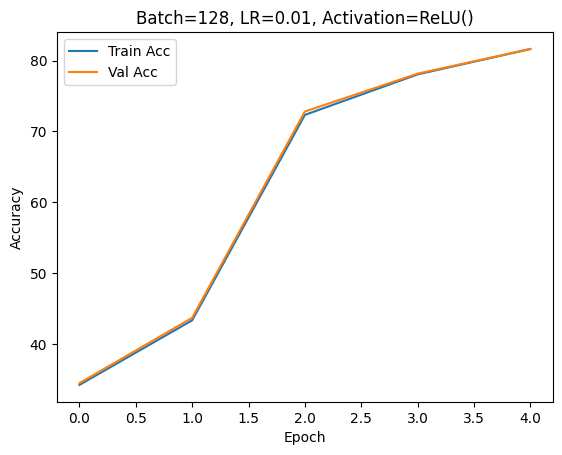

Test Loss: 0.5984, Test Acc: 82.10%
Showing up to 10 first failures:


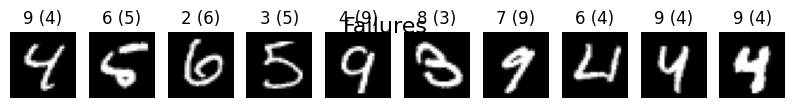


Batch Size: 128, Learning Rate: 0.01, Activation: Tanh()
Epoch 0: Train Loss: 1.9650, Train Acc: 52.50%
Epoch 0: Val Loss: 1.9634, Val Acc: 52.66%
Epoch 1: Train Loss: 1.2165, Train Acc: 65.68%
Epoch 1: Val Loss: 1.2145, Val Acc: 65.78%
Epoch 2: Train Loss: 0.8441, Train Acc: 78.73%
Epoch 2: Val Loss: 0.8428, Val Acc: 78.75%
Epoch 3: Train Loss: 0.6406, Train Acc: 83.44%
Epoch 3: Val Loss: 0.6390, Val Acc: 83.12%
Epoch 4: Train Loss: 0.5358, Train Acc: 85.67%
Epoch 4: Val Loss: 0.5333, Val Acc: 85.39%


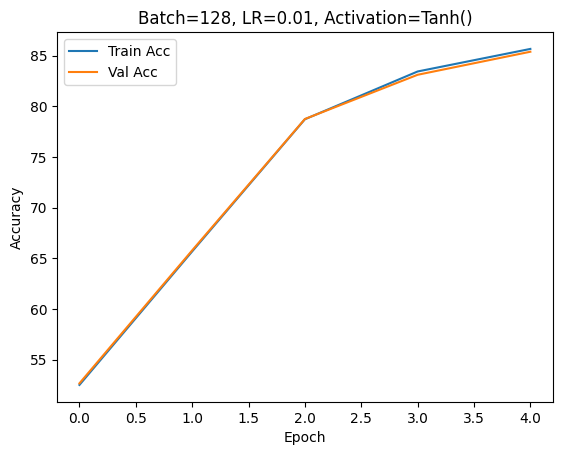

Test Loss: 0.5192, Test Acc: 85.81%
Showing up to 10 first failures:


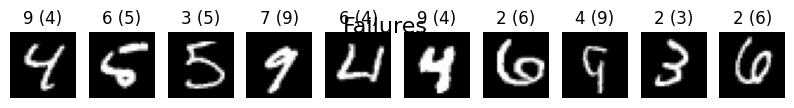


Batch Size: 128, Learning Rate: 0.05, Activation: ReLU()
Epoch 0: Train Loss: 0.5955, Train Acc: 83.04%
Epoch 0: Val Loss: 0.5885, Val Acc: 82.72%
Epoch 1: Train Loss: 0.3663, Train Acc: 89.59%
Epoch 1: Val Loss: 0.3573, Val Acc: 89.33%
Epoch 2: Train Loss: 0.3117, Train Acc: 91.00%
Epoch 2: Val Loss: 0.3040, Val Acc: 90.85%
Epoch 3: Train Loss: 0.2819, Train Acc: 91.75%
Epoch 3: Val Loss: 0.2763, Val Acc: 91.67%
Epoch 4: Train Loss: 0.2551, Train Acc: 92.46%
Epoch 4: Val Loss: 0.2533, Val Acc: 92.37%


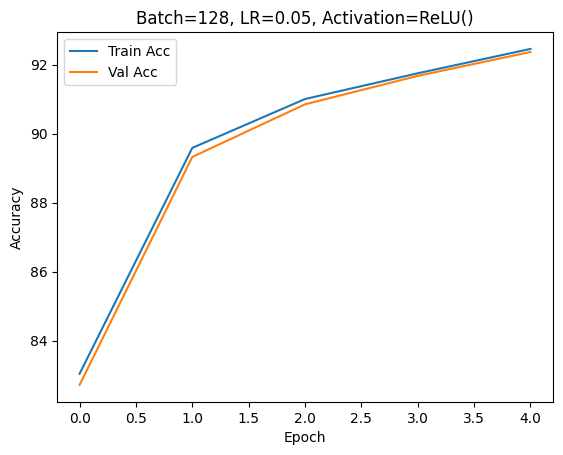

Test Loss: 0.2516, Test Acc: 92.32%
Showing up to 10 first failures:


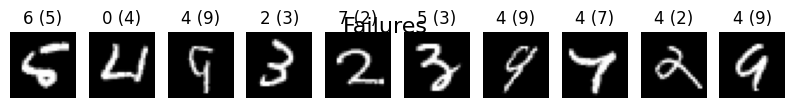


Batch Size: 128, Learning Rate: 0.05, Activation: Tanh()
Epoch 0: Train Loss: 0.5755, Train Acc: 84.78%
Epoch 0: Val Loss: 0.5741, Val Acc: 84.59%
Epoch 1: Train Loss: 0.3756, Train Acc: 89.51%
Epoch 1: Val Loss: 0.3697, Val Acc: 89.51%
Epoch 2: Train Loss: 0.3213, Train Acc: 90.89%
Epoch 2: Val Loss: 0.3157, Val Acc: 90.67%
Epoch 3: Train Loss: 0.2927, Train Acc: 91.64%
Epoch 3: Val Loss: 0.2884, Val Acc: 91.27%
Epoch 4: Train Loss: 0.2721, Train Acc: 92.09%
Epoch 4: Val Loss: 0.2703, Val Acc: 91.81%


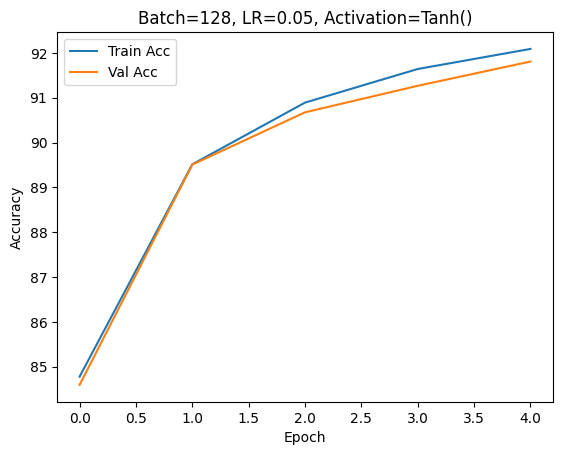

Test Loss: 0.2729, Test Acc: 91.83%
Showing up to 10 first failures:


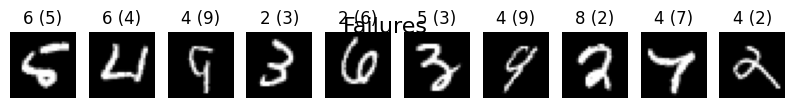


Batch Size: 128, Learning Rate: 0.1, Activation: ReLU()
Epoch 0: Train Loss: 0.4087, Train Acc: 87.97%
Epoch 0: Val Loss: 0.4000, Val Acc: 87.78%
Epoch 1: Train Loss: 0.3071, Train Acc: 90.89%
Epoch 1: Val Loss: 0.3031, Val Acc: 90.58%
Epoch 2: Train Loss: 0.2576, Train Acc: 92.26%
Epoch 2: Val Loss: 0.2554, Val Acc: 92.46%
Epoch 3: Train Loss: 0.2170, Train Acc: 93.58%
Epoch 3: Val Loss: 0.2219, Val Acc: 93.48%
Epoch 4: Train Loss: 0.1976, Train Acc: 94.01%
Epoch 4: Val Loss: 0.2036, Val Acc: 93.87%


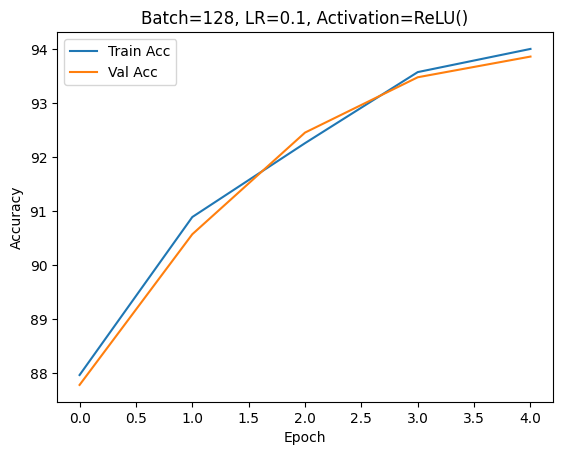

Test Loss: 0.1994, Test Acc: 93.88%
Showing up to 10 first failures:


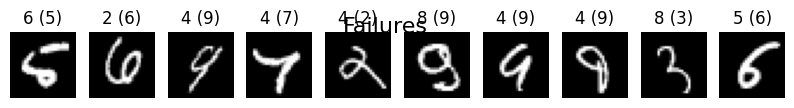


Batch Size: 128, Learning Rate: 0.1, Activation: Tanh()
Epoch 0: Train Loss: 0.3822, Train Acc: 89.20%
Epoch 0: Val Loss: 0.3735, Val Acc: 89.37%
Epoch 1: Train Loss: 0.2998, Train Acc: 91.41%
Epoch 1: Val Loss: 0.2926, Val Acc: 91.08%
Epoch 2: Train Loss: 0.2698, Train Acc: 92.14%
Epoch 2: Val Loss: 0.2663, Val Acc: 91.92%
Epoch 3: Train Loss: 0.2390, Train Acc: 93.04%
Epoch 3: Val Loss: 0.2396, Val Acc: 92.68%
Epoch 4: Train Loss: 0.2183, Train Acc: 93.61%
Epoch 4: Val Loss: 0.2219, Val Acc: 93.33%


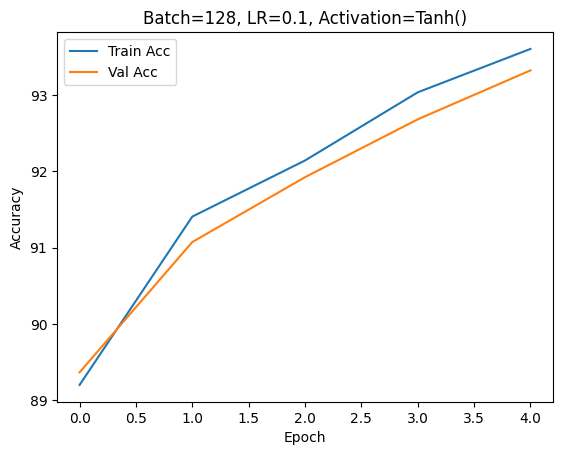

Test Loss: 0.2244, Test Acc: 93.26%
Showing up to 10 first failures:


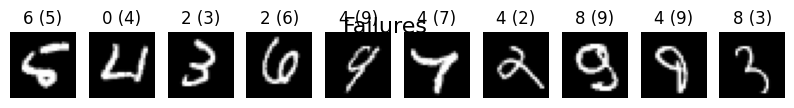


Batch Size: 256, Learning Rate: 0.01, Activation: ReLU()
Epoch 0: Train Loss: 2.2817, Train Acc: 12.67%
Epoch 0: Val Loss: 2.2824, Val Acc: 12.78%
Epoch 1: Train Loss: 2.2334, Train Acc: 33.99%
Epoch 1: Val Loss: 2.2339, Val Acc: 33.83%
Epoch 2: Train Loss: 2.1246, Train Acc: 39.18%
Epoch 2: Val Loss: 2.1249, Val Acc: 39.53%
Epoch 3: Train Loss: 1.8840, Train Acc: 40.95%
Epoch 3: Val Loss: 1.8849, Val Acc: 40.69%
Epoch 4: Train Loss: 1.5028, Train Acc: 60.97%
Epoch 4: Val Loss: 1.5043, Val Acc: 60.89%


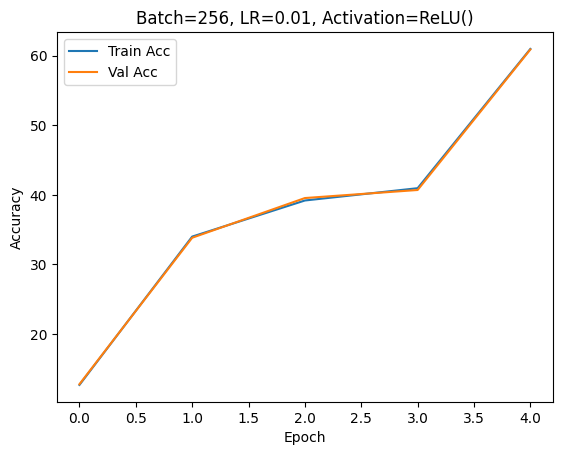

Test Loss: 1.4860, Test Acc: 61.38%
Showing up to 10 first failures:


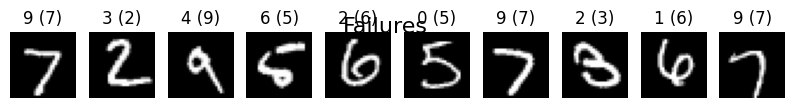


Batch Size: 256, Learning Rate: 0.01, Activation: Tanh()
Epoch 0: Train Loss: 2.1830, Train Acc: 35.87%
Epoch 0: Val Loss: 2.1819, Val Acc: 36.07%
Epoch 1: Train Loss: 1.8988, Train Acc: 39.65%
Epoch 1: Val Loss: 1.8973, Val Acc: 40.33%
Epoch 2: Train Loss: 1.5135, Train Acc: 54.30%
Epoch 2: Val Loss: 1.5087, Val Acc: 54.69%
Epoch 3: Train Loss: 1.1825, Train Acc: 69.16%
Epoch 3: Val Loss: 1.1758, Val Acc: 69.83%
Epoch 4: Train Loss: 0.9630, Train Acc: 74.85%
Epoch 4: Val Loss: 0.9557, Val Acc: 75.17%


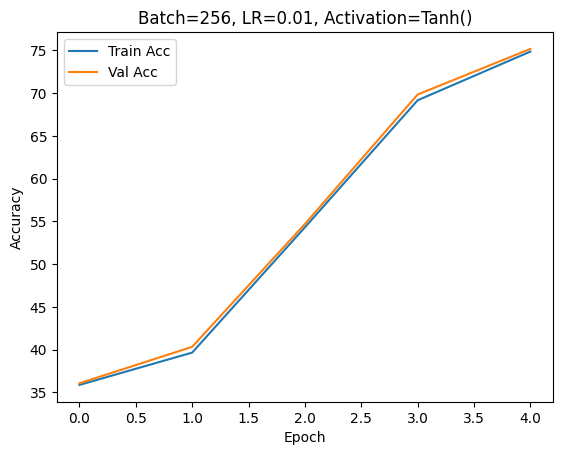

Test Loss: 0.9455, Test Acc: 75.53%
Showing up to 10 first failures:


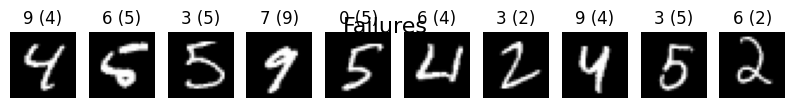


Batch Size: 256, Learning Rate: 0.05, Activation: ReLU()
Epoch 0: Train Loss: 1.3829, Train Acc: 67.60%
Epoch 0: Val Loss: 1.3781, Val Acc: 67.98%
Epoch 1: Train Loss: 0.5847, Train Acc: 82.81%
Epoch 1: Val Loss: 0.5745, Val Acc: 82.57%
Epoch 2: Train Loss: 0.4254, Train Acc: 87.69%
Epoch 2: Val Loss: 0.4181, Val Acc: 87.53%
Epoch 3: Train Loss: 0.3735, Train Acc: 89.26%
Epoch 3: Val Loss: 0.3655, Val Acc: 88.97%
Epoch 4: Train Loss: 0.3414, Train Acc: 90.09%
Epoch 4: Val Loss: 0.3343, Val Acc: 89.88%


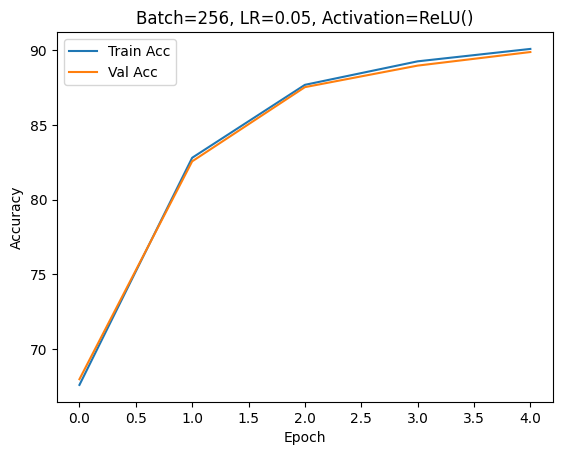

Test Loss: 0.3327, Test Acc: 89.87%
Showing up to 10 first failures:


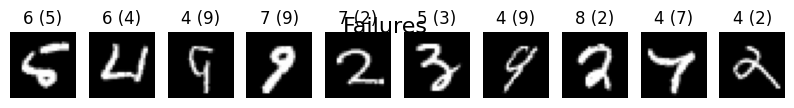


Batch Size: 256, Learning Rate: 0.05, Activation: Tanh()
Epoch 0: Train Loss: 0.9648, Train Acc: 75.07%
Epoch 0: Val Loss: 0.9616, Val Acc: 74.83%
Epoch 1: Train Loss: 0.5338, Train Acc: 85.43%
Epoch 1: Val Loss: 0.5275, Val Acc: 85.16%
Epoch 2: Train Loss: 0.4165, Train Acc: 88.46%
Epoch 2: Val Loss: 0.4080, Val Acc: 88.40%
Epoch 3: Train Loss: 0.3637, Train Acc: 89.74%
Epoch 3: Val Loss: 0.3547, Val Acc: 89.85%
Epoch 4: Train Loss: 0.3328, Train Acc: 90.56%
Epoch 4: Val Loss: 0.3248, Val Acc: 90.49%


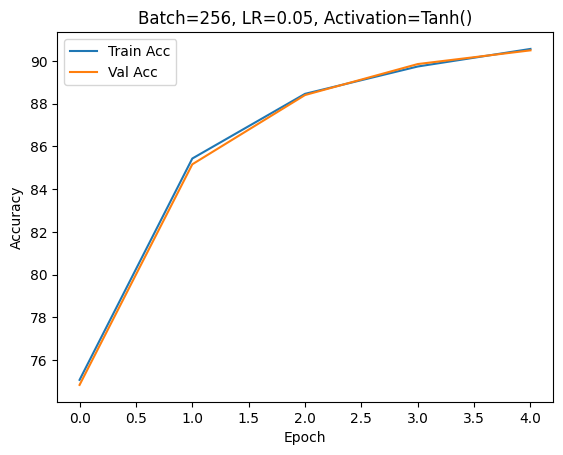

Test Loss: 0.3255, Test Acc: 90.49%
Showing up to 10 first failures:


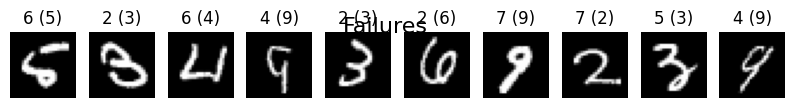


Batch Size: 256, Learning Rate: 0.1, Activation: ReLU()
Epoch 0: Train Loss: 0.6306, Train Acc: 80.73%
Epoch 0: Val Loss: 0.6203, Val Acc: 81.08%
Epoch 1: Train Loss: 0.4301, Train Acc: 87.54%
Epoch 1: Val Loss: 0.4221, Val Acc: 87.37%
Epoch 2: Train Loss: 0.3626, Train Acc: 89.39%
Epoch 2: Val Loss: 0.3567, Val Acc: 89.20%
Epoch 3: Train Loss: 0.3197, Train Acc: 90.76%
Epoch 3: Val Loss: 0.3139, Val Acc: 90.60%
Epoch 4: Train Loss: 0.2845, Train Acc: 91.76%
Epoch 4: Val Loss: 0.2824, Val Acc: 91.55%


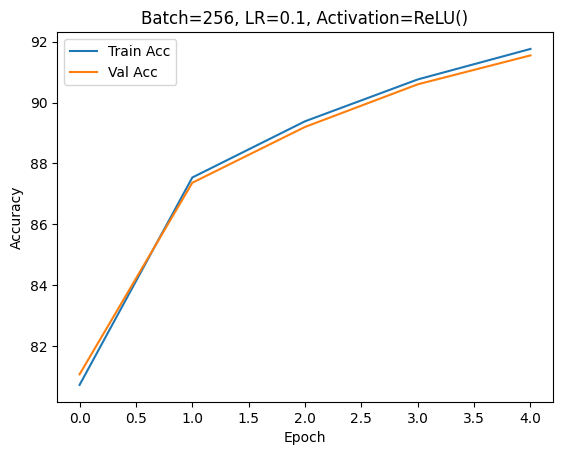

Test Loss: 0.2785, Test Acc: 91.71%
Showing up to 10 first failures:


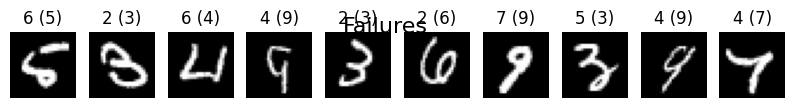


Batch Size: 256, Learning Rate: 0.1, Activation: Tanh()
Epoch 0: Train Loss: 0.6141, Train Acc: 82.89%
Epoch 0: Val Loss: 0.6057, Val Acc: 82.62%
Epoch 1: Train Loss: 0.3872, Train Acc: 89.29%
Epoch 1: Val Loss: 0.3793, Val Acc: 89.12%
Epoch 2: Train Loss: 0.3207, Train Acc: 90.99%
Epoch 2: Val Loss: 0.3110, Val Acc: 90.86%
Epoch 3: Train Loss: 0.3020, Train Acc: 91.29%
Epoch 3: Val Loss: 0.2945, Val Acc: 91.29%
Epoch 4: Train Loss: 0.2802, Train Acc: 91.85%
Epoch 4: Val Loss: 0.2757, Val Acc: 91.70%


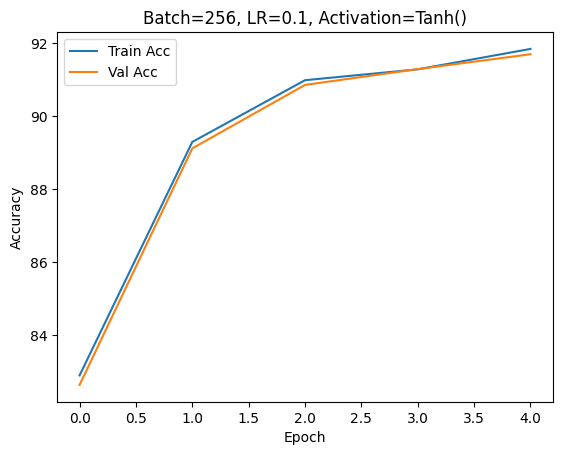

Test Loss: 0.2809, Test Acc: 91.56%
Showing up to 10 first failures:


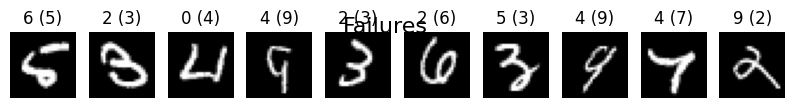

In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import torch
import torchvision
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import time

#######################################################################################
epoch = 5
batch_list = [64, 128, 256]
batch_test = 256
learning_rates_list = [0.01, 0.05, 0.1]
activation_funcs = [nn.ReLU(), nn.Tanh()]
#######################################################################################

# Load MNIST dataset
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Split training data into training and validation sets
train_size = int(0.8 * len(training_data))
val_size = len(training_data) - train_size
training_data, validation_data = torch.utils.data.random_split(
    training_data, [train_size, val_size], generator=torch.Generator().manual_seed(55)
)

print(f'MNIST data loaded: train={len(training_data)}, val={len(validation_data)}, test={len(test_data)}')
print('Input shape:', training_data[0][0].shape)

# Define the model class with dynamic activation function
class NonlinearClassifier(nn.Module):
    def __init__(self, activation_func):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            nn.Linear(28 * 28, 50),
            nn.Dropout(0.2),
            nn.Linear(50, 50),
            activation_func,  # Dynamic activation function
            nn.Linear(50, 50),
            activation_func,  # Dynamic activation function
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.layers_stack(x)

# Function to train one epoch
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

# Function to evaluate the model
def evaluate(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy = 100 * correct / size
    return accuracy, loss

# Function to display failure cases
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    rounded = predictions.argmax(1)
    errors = rounded != batch[1]

    print('Showing up to', maxtoshow, 'first failures:')
    plt.figure(figsize=(maxtoshow, 1))
    plt.suptitle("Failures", fontsize=16)
    ii = 0
    for i in range(batch[0].shape[0]):
        if ii >= maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii + 1)
            plt.axis('off')
            plt.imshow(batch[0][i, 0, :, :], cmap="gray")
            plt.title(f"{rounded[i]} ({batch[1][i]})")
            ii += 1

# Main loop to try different combinations
for batch in batch_list:
    for learning_rate in learning_rates_list:
        for activation_func in activation_funcs:
            print(f"\nBatch Size: {batch}, Learning Rate: {learning_rate}, Activation: {activation_func}")

            # Initialize model, loss function, and optimizer
            nonlinear_model = NonlinearClassifier(activation_func)
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=learning_rate)

            # DataLoaders for training and validation
            train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch)
            val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch)

            # Train and evaluate the model
            train_acc_all, val_acc_all = [], []

            for epoch_num in range(epoch):
                train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)

                # Training accuracy and loss
                train_acc, train_loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
                train_acc_all.append(train_acc)
                print(f"Epoch {epoch_num}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

                # Validation accuracy and loss
                val_acc, val_loss = evaluate(val_dataloader, nonlinear_model, loss_fn)
                val_acc_all.append(val_acc)
                print(f"Epoch {epoch_num}: Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Plot training and validation accuracy
            plt.figure()
            plt.plot(range(epoch), train_acc_all, label='Train Acc')
            plt.plot(range(epoch), val_acc_all, label='Val Acc')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.title(f"Batch={batch}, LR={learning_rate}, Activation={activation_func}")
            plt.show()

            # Test the model
            test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_test)
            test_acc, test_loss = evaluate(test_dataloader, nonlinear_model, loss_fn)
            print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

            # Show failure cases
            show_failures(nonlinear_model, test_dataloader)
            plt.show()